https://github.com/huggingface/peft/blob/main/examples/fp4_finetuning/finetune_fp4_opt_bnb_peft.py

In [1]:
from torch import optim
import lightning as pl
from matplotlib import pyplot as plt

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoConfig
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import warnings
from peft import LoraConfig, get_peft_model, IA3Config

In [3]:
plt.style.use('ggplot')
torch.set_float32_matmul_precision('medium')
warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [4]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

model_name = "microsoft/phi-2"

# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     # max_memory=max_memory,
#     quantization_config=BitsAndBytesConfig(
#         load_in_4bit=True,
#         llm_int8_threshold=6.0,
#         llm_int8_has_fp16_weight=False,
#         bnb_4bit_compute_dtype=torch.float16,
#         bnb_4bit_use_double_quant=True,
#         bnb_4bit_quant_type="nf4",
#     ),
#     torch_dtype=torch.float16,
#     trust_remote_code=True,
# )






In [5]:
model_name = "TheBloke/phi-2-GPTQ"
# model_name = "microsoft/phi-2"

def load_model():

    # model = AutoModelForCausalLM.from_pretrained(
    #     model_name,
    #     # quantization_config=BitsAndBytesConfig(
    #     #     load_in_4bit=True,
    #     #     llm_int8_threshold=6.0,
    #     #     llm_int8_has_fp16_weight=False,
    #     #     bnb_4bit_compute_dtype=torch.float16,
    #     #     bnb_4bit_use_double_quant=True,
    #     #     bnb_4bit_quant_type="nf4",
    #     # ),
    #     torch_dtype=torch.float16,
    #     trust_remote_code=True,
    # )


    config = AutoConfig.from_pretrained(model_name, trust_remote_code=True,)
    config.quantization_config['use_exllama'] = False
    config.quantization_config['disable_exllama'] = True
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        trust_remote_code=True,
        config=config,
    )
    return model


In [6]:
base_model = load_model()
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True,)
tokenizer.pad_token = tokenizer.eos_token

CUDA extension not installed.
CUDA extension not installed.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
def reset_model(base_model):
    peft_config = LoraConfig(
        # task_type=TaskType.TOKEN_CLS, 
        target_modules=[ "fc2",  "Wqkv",],
        inference_mode=False, r=4, lora_alpha=4, 
        # lora_dropout=0.1, 
        # bias="all"
    )
    # peft_config = IA3Config(
    #     target_modules=[ "fc2",  "Wqkv",], 
    #         feedforward_modules=["fc2"],
    #         inference_mode=False,
    # )
    model = get_peft_model(base_model, peft_config)
    model.config.use_cache = False
    return model

model = reset_model(base_model)

In [8]:
import json
MAX_LEN = 2000
samples = json.load(open("../samples.json"))


## Helpers

In [9]:
# modified from https://github.dev/huggingface/evaluate/blob/8dfe05784099fb9af55b8e77793205a3b7c86465/measurements/perplexity/perplexity.py#L154

# from evaluate.measurements.perplexity import Perplexity
import evaluate
from evaluate import logging
from torch.nn import CrossEntropyLoss

# @evaluate.utils.file_utils.add_start_docstrings(_DESCRIPTION, _KWARGS_DESCRIPTION)
def perplexity_compute(
    data, model, tokenizer, batch_size: int = 16, add_start_token: bool = True, device=None, max_length=None
):

    if device is not None:
        assert device in ["gpu", "cpu", "cuda"], "device should be either gpu or cpu."
        if device == "gpu":
            device = "cuda"
    else:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # model = AutoModelForCausalLM.from_pretrained(model_id)
    model = model.to(device)

    # tokenizer = AutoTokenizer.from_pretrained(model_id)

    # # if batch_size > 1 (which generally leads to padding being required), and
    # # if there is not an already assigned pad_token, assign an existing
    # # special token to also be the padding token
    # if tokenizer.pad_token is None and batch_size > 1:
    #     existing_special_tokens = list(tokenizer.special_tokens_map_extended.values())
    #     # check that the model already has at least one special token defined
    #     assert (
    #         len(existing_special_tokens) > 0
    #     ), "If batch_size > 1, model must have at least one special token to use for padding. Please use a different model or set batch_size=1."
    #     # assign one of the special tokens to also be the pad token
    #     tokenizer.add_special_tokens({"pad_token": existing_special_tokens[0]})

    # if add_start_token and max_length:
    #     # leave room for <BOS> token to be added:
    #     assert (
    #         tokenizer.bos_token is not None
    #     ), "Input model must already have a BOS token if using add_start_token=True. Please use a different model, or set add_start_token=False"
    #     max_tokenized_len = max_length - 1
    # else:
    max_tokenized_len = max_length

    encodings = tokenizer(
        data,
        add_special_tokens=False,
        padding=True,
        truncation=True if max_tokenized_len else False,
        max_length=max_tokenized_len,
        return_tensors="pt",
        return_attention_mask=True,
    ).to(device)

    encoded_texts = encodings["input_ids"]
    attn_masks = encodings["attention_mask"]

    # check that each input is long enough:
    if add_start_token:
        assert torch.all(torch.ge(attn_masks.sum(1), 1)), "Each input text must be at least one token long."
    else:
        assert torch.all(
            torch.ge(attn_masks.sum(1), 2)
        ), "When add_start_token=False, each input text must be at least two tokens long. Run with add_start_token=True if inputting strings of only one token, and remove all empty input strings."

    ppls = []
    loss_fct = CrossEntropyLoss(reduction="none")

    for start_index in logging.tqdm(range(0, len(encoded_texts), batch_size)):
        end_index = min(start_index + batch_size, len(encoded_texts))
        encoded_batch = encoded_texts[start_index:end_index]
        attn_mask = attn_masks[start_index:end_index]

        # if add_start_token:
        #     bos_tokens_tensor = torch.tensor([[tokenizer.bos_token_id]] * encoded_batch.size(dim=0)).to(device)
        #     encoded_batch = torch.cat([bos_tokens_tensor, encoded_batch], dim=1)
        #     attn_mask = torch.cat(
        #         [torch.ones(bos_tokens_tensor.size(), dtype=torch.int64).to(device), attn_mask], dim=1
        #     )

        labels = encoded_batch

        with torch.no_grad():
            out_logits = model(encoded_batch, attention_mask=attn_mask).logits
            # print(out_logits.shape)

        shift_logits = out_logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_attention_mask_batch = attn_mask[..., 1:].contiguous()

        perplexity_batch = torch.exp(
            (loss_fct(shift_logits.transpose(1, 2), shift_labels) * shift_attention_mask_batch).sum(1)
            / shift_attention_mask_batch.sum(1)
        )
        # perplexity_batch = torch.exp(
        #     (loss_fct(shift_logits.transpose(1, 2), shift_labels) * shift_attention_mask_batch)
        #     / shift_attention_mask_batch.sum(1)
        # )
        # print(perplexity_batch.shape)

        ppls += perplexity_batch.tolist()

    return {"perplexities": ppls, "mean_perplexity": torch.tensor(ppls).mean()}

In [10]:
# perplexity_compute(
#     second_half, model, tokenizer
# )

## Training

In [11]:
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

## Lightning helpers

In [12]:




# def str2xya(s, tokenizer):
#     max_len = min(MAX_LEN, len(s))
#     input_ids = tokenizer(s, return_tensors="pt")["input_ids"][0]

#     pad = tokenizer.bos_token_id
#     data = []
#     for i in range(1, len(input_ids)):
#         x = input_ids[:i][-max_len:]
#         padding = max_len - len(x)
#         x = torch.tensor([pad]*padding + x.tolist())

#         labels = input_ids[i:i+1]
#         attention_mask = (x==pad)*1
#         data.append(dict(input_ids=x, labels=labels, attention_mask=attention_mask, return_loss=True))
        
#     return data



In [13]:
def eval(model, tokenizer, second_half):
    model.eval();
    with torch.no_grad():
        with model.disable_adapter():
            results = perplexity_compute(data=second_half, model=model, tokenizer=tokenizer, device='cuda')
        results2 = perplexity_compute(data=second_half, model=model, tokenizer=tokenizer, device='cuda')
    return dict(before=results['mean_perplexity'].item(), after=results2['mean_perplexity'].item())


# Train

In [14]:
from datasets import Dataset


def compute_metrics(eval_prediction):
    return {}

Trainer docs

- https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/trainer#transformers.Trainer

In [15]:
def learn_sample(sample):
    # device = 'cuda'
    # lr = 4e-3
    # epochs = 3
    # accum_steps = 1
    batch_size = 6
    verbose = True

    s = sample['text']
    first_half = s[:len(s)//2]
    second_half = s[len(s)//2:]
    ds_train = Dataset.from_dict(tokenizer([first_half]))
    ds_val = Dataset.from_dict(tokenizer([second_half]))

    os.environ['CUDA_VISIBLE_DEVICES']="1"
    model = reset_model(base_model)
    eval(model, tokenizer, second_half)

    # https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/trainer#transformers.Trainer
    trainer = transformers.Trainer(
        model=model,
        train_dataset=ds_train,
        eval_dataset=ds_val,
        compute_metrics=compute_metrics, # without this it wont even give val loss
        args=transformers.TrainingArguments(
            label_names=['labels',],
            per_device_train_batch_size=batch_size,
            gradient_accumulation_steps=8,
            warmup_steps=0,
            max_steps=3,
            learning_rate=3e-4,
            fp16=True,
            logging_steps=1,
            output_dir="outputs",
            log_level='error',
            # do_eval=True,
            evaluation_strategy="epoch",
            eval_steps=1,
            
            # disable_tqdm=not verbose,
        ),
        data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    )
    trainer._signature_columns = ['input_ids', 'attention_mask', 'labels',]
    model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
    train_output = trainer.train()

    df_hist = pd.DataFrame(trainer.state.log_history)
    df_hist_epoch = df_hist.groupby('epoch').last().dropna(axis=1).drop(columns=['step'])
    df_hist_step = df_hist.set_index('step').dropna(thresh=2, axis=1)
    if verbose:
        df_hist_epoch[['eval_loss', 'loss']].plot()
        # for c in df_hist_epoch.columns:
        #     df_hist_epoch[[c]].plot()


    result_train = {f'train/{k}':v for k,v in eval(model, tokenizer, first_half).items()}
    result = eval(model, tokenizer, second_half)
    result['hist'] = df_hist_epoch
    result.update(result_train)
    return result


bad_ml


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
  0%|          | 0/3 [00:00<?, ?it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 33%|███▎      | 1/3 [00:00<00:00,  2.14it/s]

{'loss': 0.3704, 'learning_rate': 0.00019999999999999998, 'epoch': 1.0}


                                             
 33%|███▎      | 1/3 [00:00<00:00,  2.14it/s]

{'eval_loss': 2.638835906982422, 'eval_runtime': 0.1861, 'eval_samples_per_second': 5.372, 'eval_steps_per_second': 5.372, 'epoch': 1.0}


 67%|██████▋   | 2/3 [00:00<00:00,  2.21it/s]

{'loss': 0.3592, 'learning_rate': 9.999999999999999e-05, 'epoch': 2.0}


                                             
 67%|██████▋   | 2/3 [00:01<00:00,  2.21it/s]

{'eval_loss': 2.6423683166503906, 'eval_runtime': 0.1871, 'eval_samples_per_second': 5.344, 'eval_steps_per_second': 5.344, 'epoch': 2.0}


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

{'loss': 0.3644, 'learning_rate': 0.0, 'epoch': 3.0}


                                             
100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


{'eval_loss': 2.6508710384368896, 'eval_runtime': 0.1846, 'eval_samples_per_second': 5.417, 'eval_steps_per_second': 5.417, 'epoch': 3.0}
{'train_runtime': 1.547, 'train_samples_per_second': 186.162, 'train_steps_per_second': 1.939, 'train_loss': 0.36465682586034137, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


{'before': 14.047965049743652, 'after': 14.164684295654297}
good_ml


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4351, 'learning_rate': 0.00019999999999999998, 'epoch': 1.0}
{'eval_loss': 3.3168678283691406, 'eval_runtime': 0.1771, 'eval_samples_per_second': 5.646, 'eval_steps_per_second': 5.646, 'epoch': 1.0}
{'loss': 0.4282, 'learning_rate': 9.999999999999999e-05, 'epoch': 2.0}
{'eval_loss': 3.3044259548187256, 'eval_runtime': 0.1859, 'eval_samples_per_second': 5.379, 'eval_steps_per_second': 5.379, 'epoch': 2.0}
{'loss': 0.4142, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.3050894737243652, 'eval_runtime': 0.1802, 'eval_samples_per_second': 5.548, 'eval_steps_per_second': 5.548, 'epoch': 3.0}
{'train_runtime': 1.2802, 'train_samples_per_second': 224.971, 'train_steps_per_second': 2.343, 'train_loss': 0.42586277921994525, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


{'before': 28.013324737548828, 'after': 27.2460994720459}
sokal hoax


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.3474, 'learning_rate': 0.00019999999999999998, 'epoch': 1.0}
{'eval_loss': 2.8345842361450195, 'eval_runtime': 0.2168, 'eval_samples_per_second': 4.612, 'eval_steps_per_second': 4.612, 'epoch': 1.0}
{'loss': 0.3373, 'learning_rate': 9.999999999999999e-05, 'epoch': 2.0}
{'eval_loss': 2.8268091678619385, 'eval_runtime': 0.2203, 'eval_samples_per_second': 4.539, 'eval_steps_per_second': 4.539, 'epoch': 2.0}
{'loss': 0.3206, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 2.822420597076416, 'eval_runtime': 0.2226, 'eval_samples_per_second': 4.492, 'eval_steps_per_second': 4.492, 'epoch': 3.0}
{'train_runtime': 1.6037, 'train_samples_per_second': 179.59, 'train_steps_per_second': 1.871, 'train_loss': 0.33505648374557495, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


{'before': 17.25156021118164, 'after': 16.81453514099121}
Theory o. general relativity


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4003, 'learning_rate': 0.00019999999999999998, 'epoch': 1.0}
{'eval_loss': 3.314274311065674, 'eval_runtime': 0.222, 'eval_samples_per_second': 4.505, 'eval_steps_per_second': 4.505, 'epoch': 1.0}
{'loss': 0.3866, 'learning_rate': 9.999999999999999e-05, 'epoch': 2.0}
{'eval_loss': 3.284952163696289, 'eval_runtime': 0.2303, 'eval_samples_per_second': 4.341, 'eval_steps_per_second': 4.341, 'epoch': 2.0}
{'loss': 0.3706, 'learning_rate': 0.0, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


{'eval_loss': 3.272625207901001, 'eval_runtime': 0.2167, 'eval_samples_per_second': 4.615, 'eval_steps_per_second': 4.615, 'epoch': 3.0}
{'train_runtime': 1.6267, 'train_samples_per_second': 177.042, 'train_steps_per_second': 1.844, 'train_loss': 0.38583876689275104, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


{'before': 27.831388473510742, 'after': 26.375333786010742}
lorem ipsum 


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0386, 'learning_rate': 0.00019999999999999998, 'epoch': 1.0}
{'eval_loss': 0.5342217087745667, 'eval_runtime': 0.2057, 'eval_samples_per_second': 4.862, 'eval_steps_per_second': 4.862, 'epoch': 1.0}
{'loss': 0.0355, 'learning_rate': 9.999999999999999e-05, 'epoch': 2.0}
{'eval_loss': 0.5338245630264282, 'eval_runtime': 0.2084, 'eval_samples_per_second': 4.798, 'eval_steps_per_second': 4.798, 'epoch': 2.0}
{'loss': 0.0294, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 0.5344500541687012, 'eval_runtime': 0.2057, 'eval_samples_per_second': 4.86, 'eval_steps_per_second': 4.86, 'epoch': 3.0}
{'train_runtime': 1.5636, 'train_samples_per_second': 184.194, 'train_steps_per_second': 1.919, 'train_loss': 0.03448754859467348, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


{'before': 1.7382311820983887, 'after': 1.7063310146331787}
wikipedia on LK-99


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.3778, 'learning_rate': 0.00019999999999999998, 'epoch': 1.0}
{'eval_loss': 3.4620773792266846, 'eval_runtime': 0.2343, 'eval_samples_per_second': 4.267, 'eval_steps_per_second': 4.267, 'epoch': 1.0}
{'loss': 0.3518, 'learning_rate': 9.999999999999999e-05, 'epoch': 2.0}
{'eval_loss': 3.4619271755218506, 'eval_runtime': 0.232, 'eval_samples_per_second': 4.311, 'eval_steps_per_second': 4.311, 'epoch': 2.0}
{'loss': 0.3405, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 3.446701765060425, 'eval_runtime': 0.4353, 'eval_samples_per_second': 2.297, 'eval_steps_per_second': 2.297, 'epoch': 3.0}
{'train_runtime': 1.9791, 'train_samples_per_second': 145.52, 'train_steps_per_second': 1.516, 'train_loss': 0.3567004104455312, 'epoch': 3.0}


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


{'before': 33.34950256347656, 'after': 31.391511917114258}
I have a dream


  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

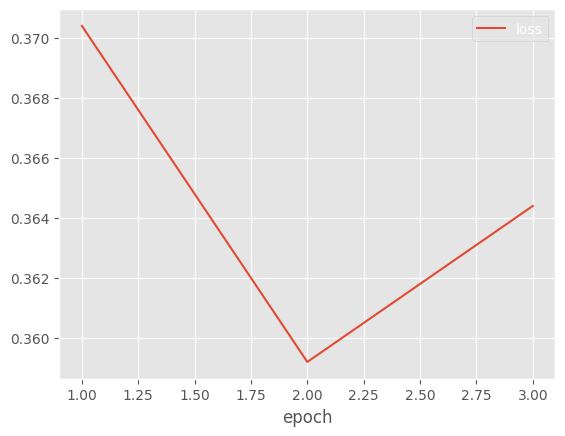

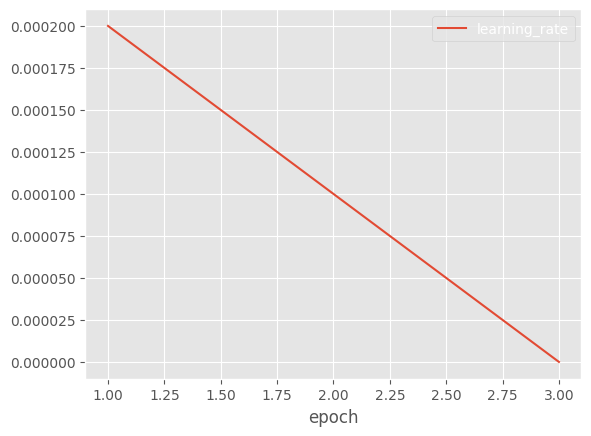

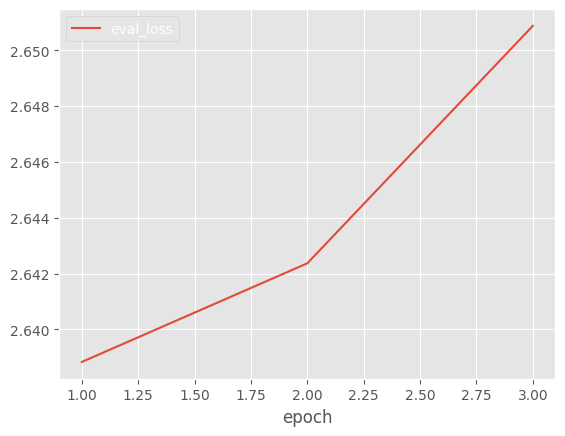

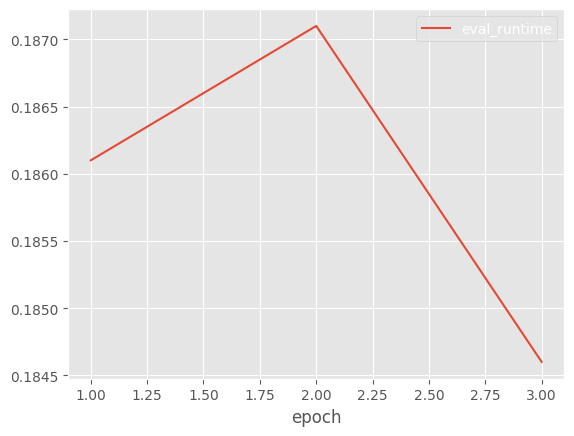

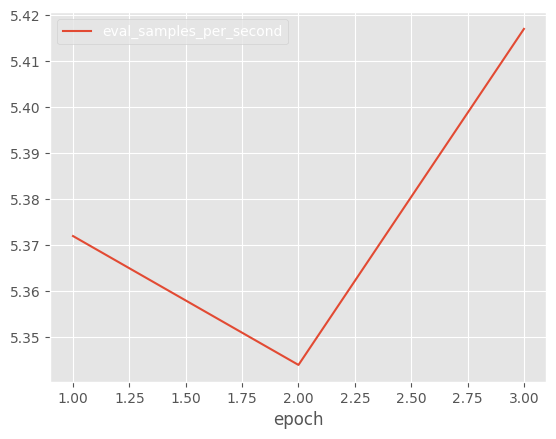

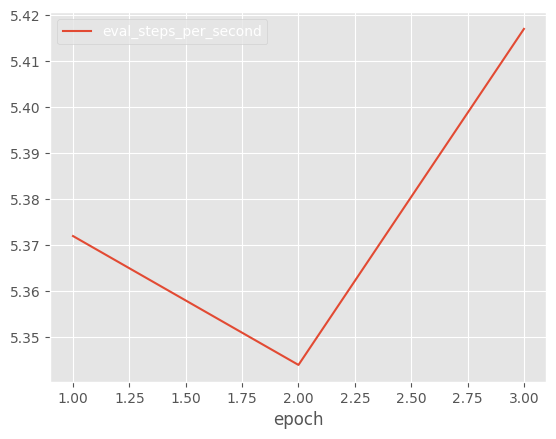

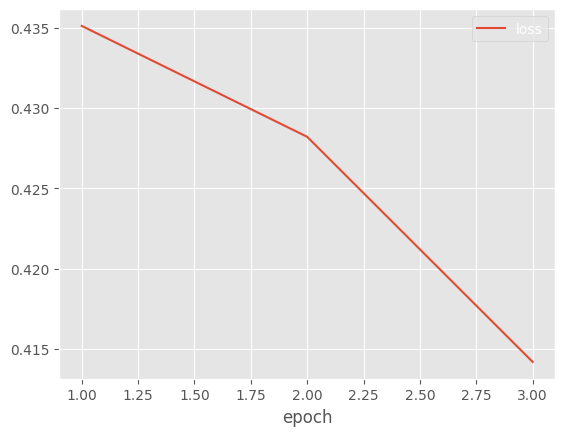

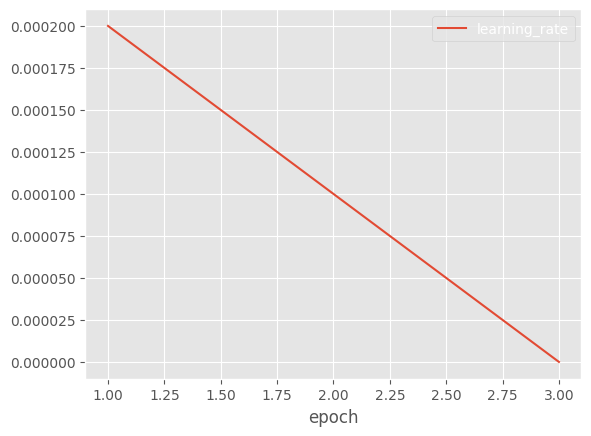

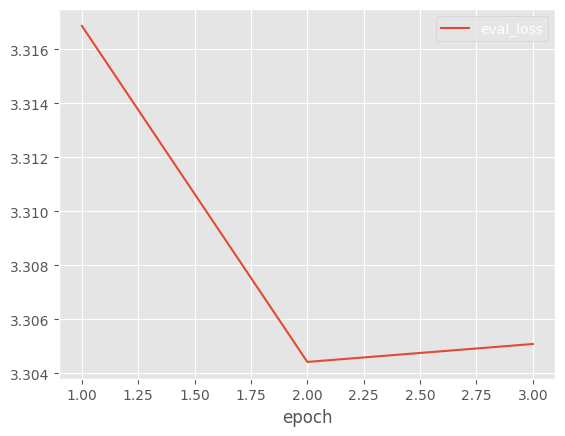

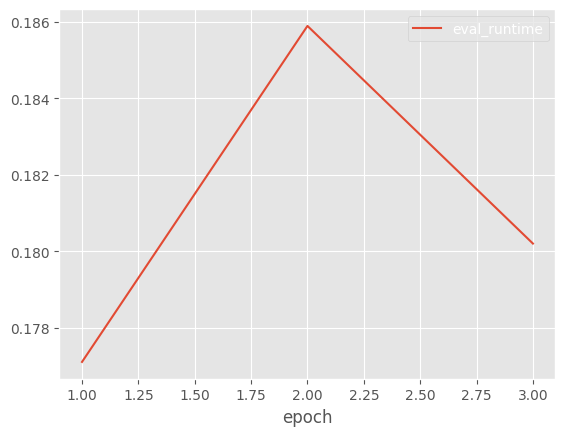

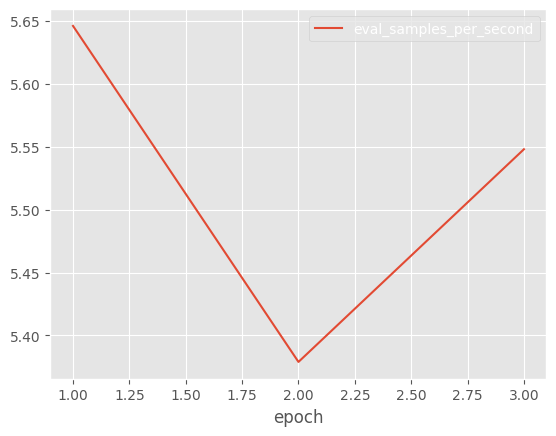

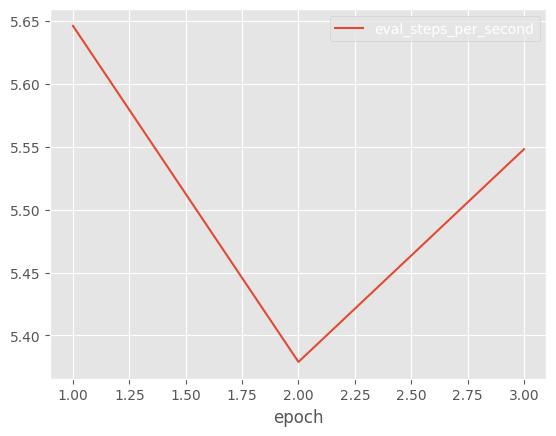

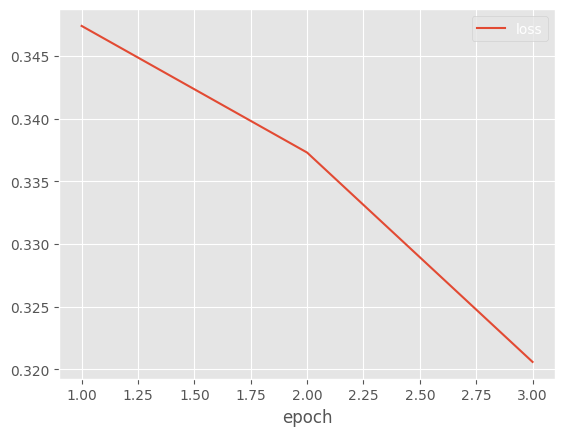

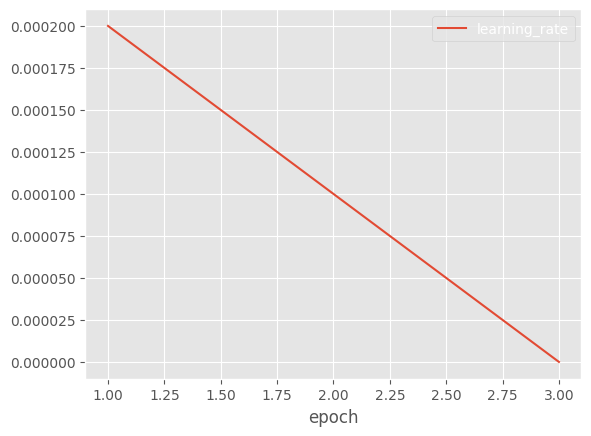

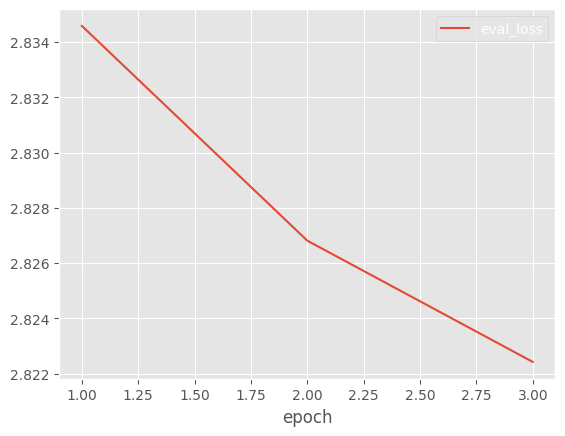

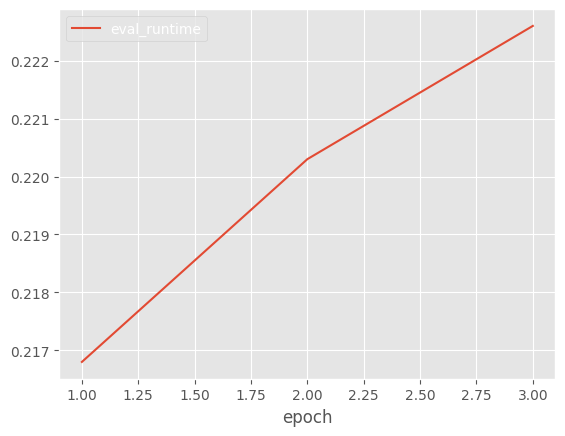

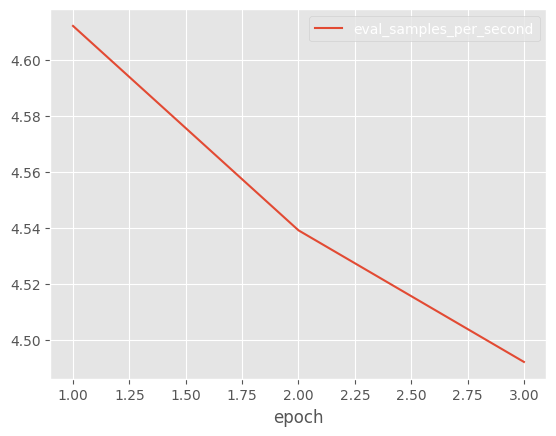

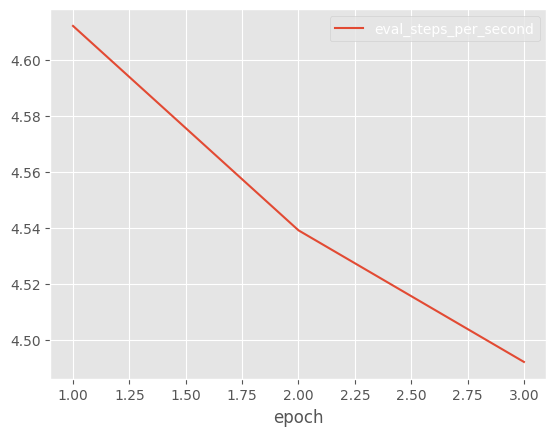

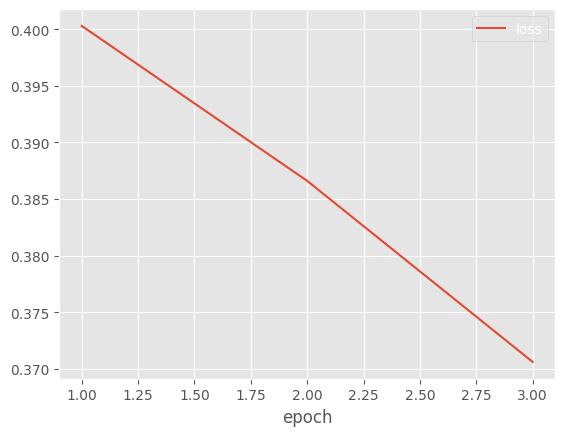

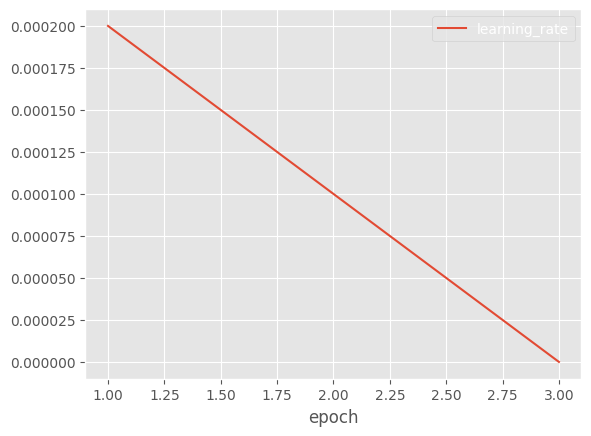

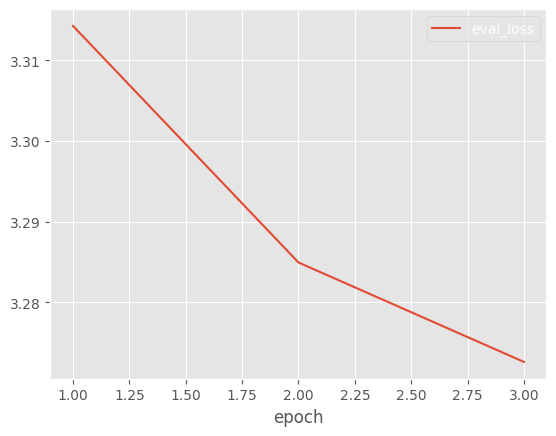

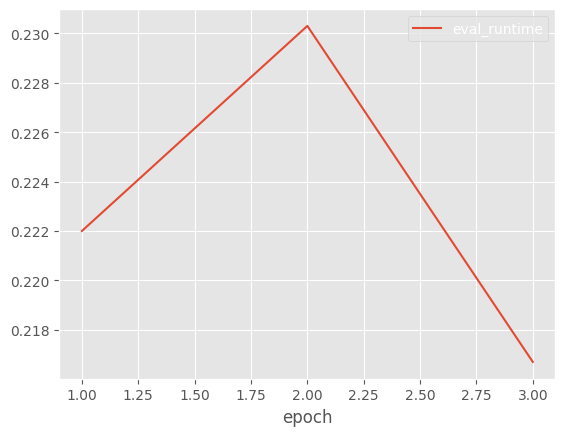

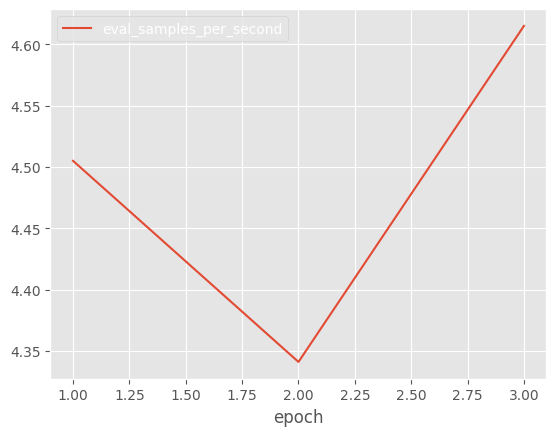

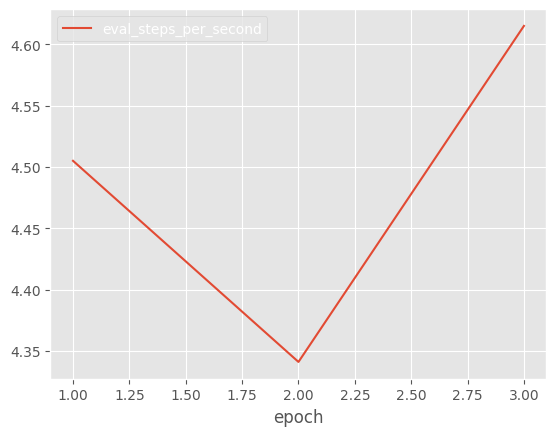

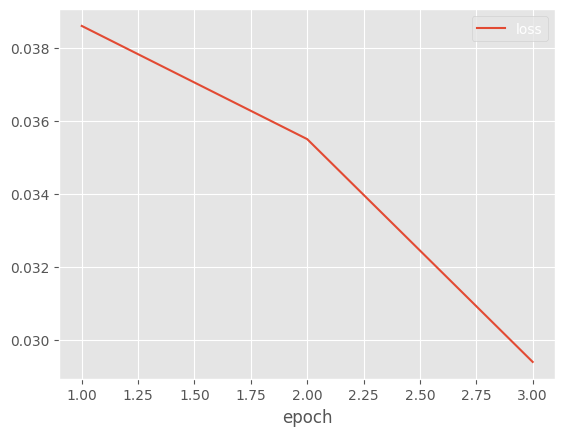

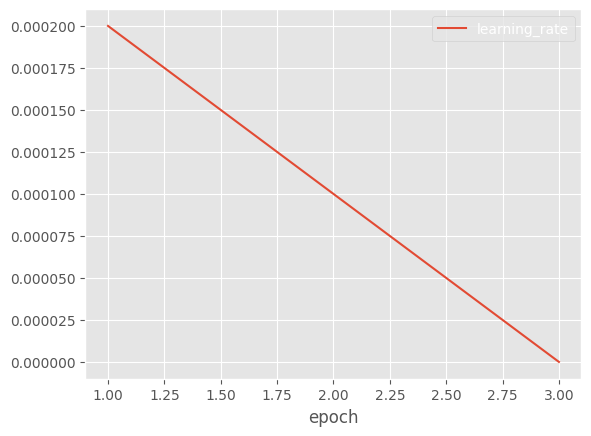

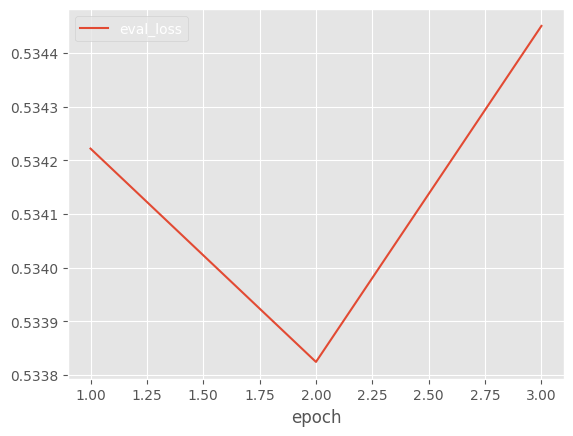

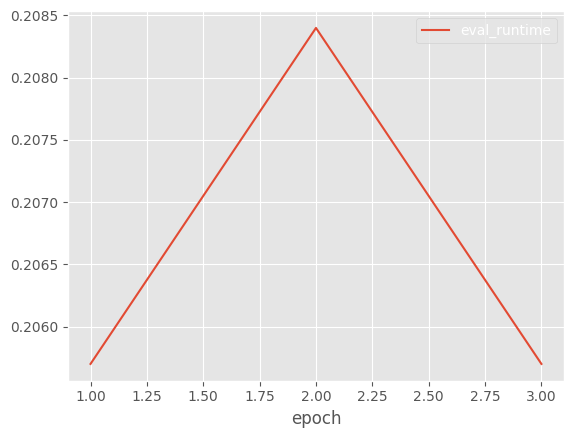

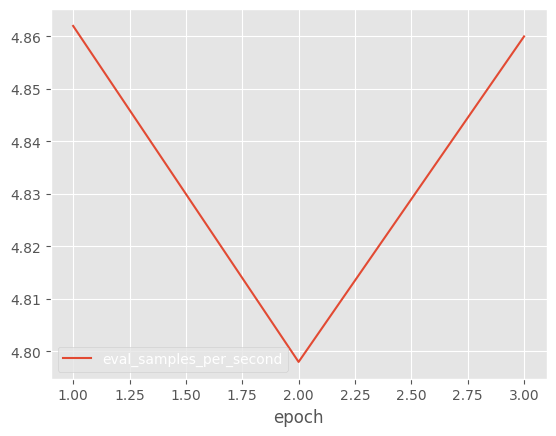

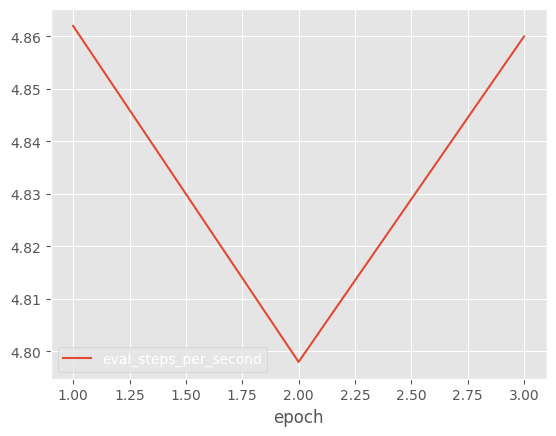

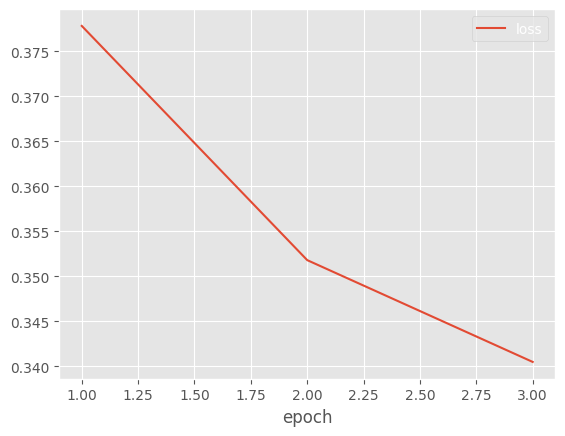

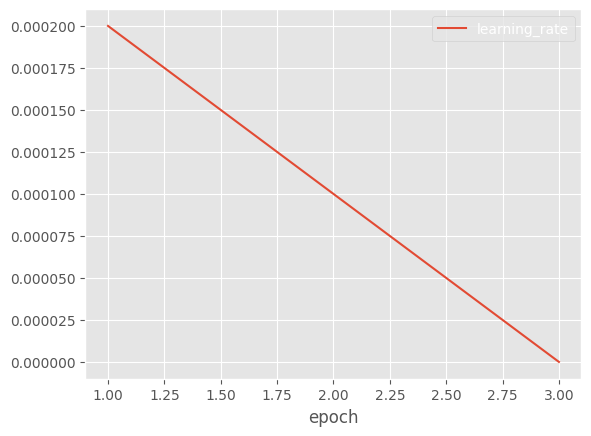

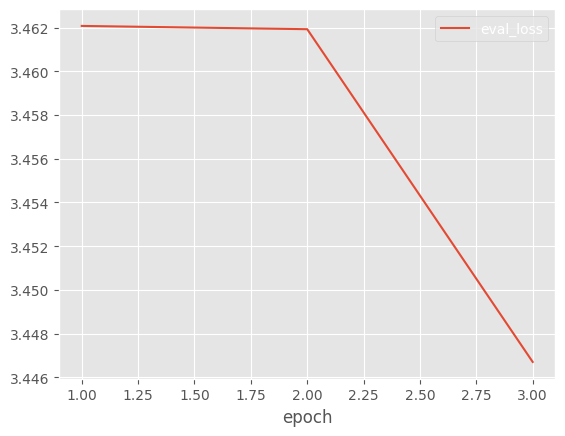

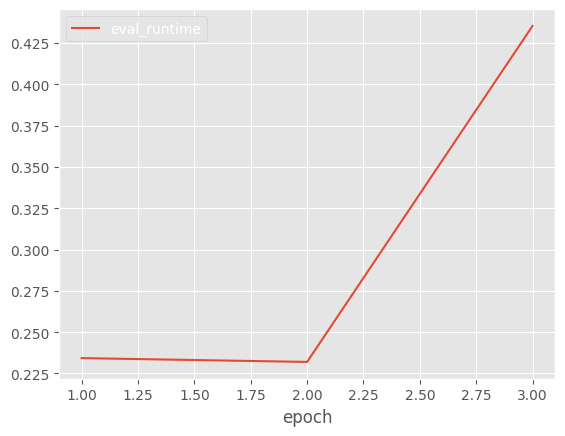

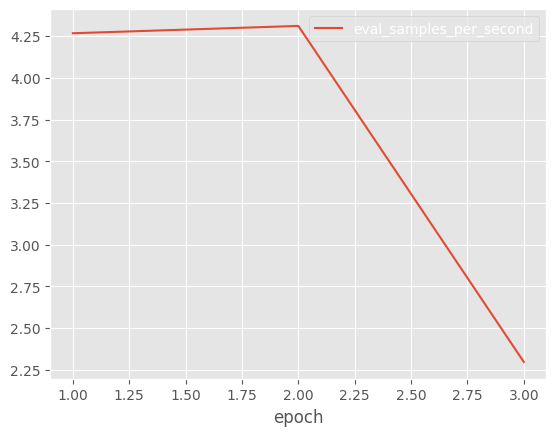

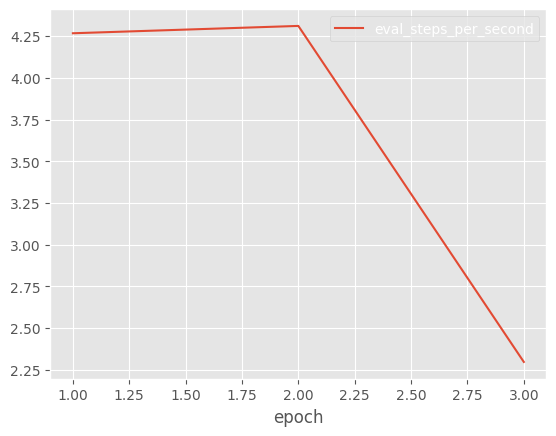

In [16]:
data = []
for sample in samples:
    print(sample['name'])
    r = learn_sample(sample)
    print(dict(before=r['before'], after=r['after']))
    data.append(dict(**r, **sample))

,eval_loss,loss
epoch,,
1.0,2.638836,0.3704
2.0,2.642368,0.3592
3.0,2.650871,0.3644


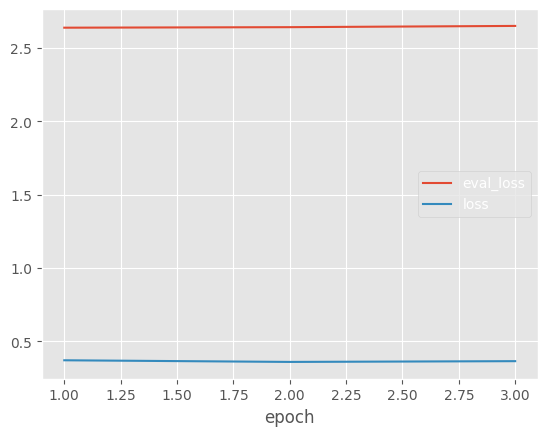

In [17]:
df_hist = data[0]['hist']#.groupby('epoch').last().dropna(axis=1).drop(columns=['step'])
df_hist[['eval_loss', 'loss']].plot()
df_hist[['eval_loss', 'loss']]


### Perplexity

Perplexity measures how well a language model predicts a text sample. Lower is better

It’s calculated as the average number of bits per word a model needs to represent the same

https://huggingface.co/docs/transformers/perplexity
https://thegradient.pub/understanding-evaluation-metrics-for-language-models/


In [18]:

df_res = pd.DataFrame(data)
df_res = df_res[['before', 'after', 'name', 'in_training']].set_index('name')
df_res['improvement'] = df_res['before'] - df_res['after']
df_res.sort_values('improvement', ascending=False)

,before,after,in_training,improvement
name,,,,
wikipedia on LK-99,33.349503,31.391512,False,1.957991
Theory o. general relativity,27.831388,26.375334,True,1.456055
good_ml,28.013325,27.246099,False,0.767225
sokal hoax,17.251560,16.814535,True,0.437025
lorem ipsum,1.738231,1.706331,True,0.031900
bad_ml,14.047965,14.164684,False,-0.116719


# DEBUG

In [ ]:
from IPython.display import display, HTML, Markdown
import torch

@torch.no_grad()
def gen(model, inputs, tokenizer, clean=True):
    s = model.generate(
        input_ids=inputs["input_ids"][None, :].to(model.device),
        attention_mask=inputs["attention_mask"][None, :].to(model.device),
        use_cache=False,
        max_new_tokens=100,
        min_new_tokens=100,
        do_sample=False,
        early_stopping=False,
    )
    input_l = inputs["input_ids"].shape[0]
    tokenizer_kwargs=dict(clean_up_tokenization_spaces=clean, skip_special_tokens=clean)
    old = tokenizer.decode(
        s[0, :input_l], **tokenizer_kwargs
    )
    new = tokenizer.decode(
        s[0, input_l:], **tokenizer_kwargs
    )
    s_old = ""+old.replace('\n', '<br>')
    s_new =  '<b>' + new.replace('\n', '<br>')+ '<br><br><b/>'
    display(HTML(f"{s_old}{s_new}"))
    # print([old, new])



In [ ]:
samples = samples[1]

s = sample['text']
first_half = s[:len(s)//2]
second_half = s[len(s)//2:]
ds_train = Dataset.from_dict(tokenizer([first_half]))
ds_val = Dataset.from_dict(tokenizer([second_half]))

In [ ]:
with model.disable_adapter():
    gen(model, ds_train.with_format('pt')[0], tokenizer)

In [ ]:
gen(model, ds_train.with_format('pt')[0], tokenizer)